<img src="images/dask_horizontal.svg" align="right" width="30%">

# Distributed

As we have seen so far, Dask allows you to simply construct graphs of tasks with dependencies, as well as have graphs created automatically for you using functional, Numpy or Pandas syntax on data collections. None of this would be very useful, if there weren't also a way to execute these graphs, in a parallel and memory-aware way. So far we have been calling `thing.compute()` or `dask.compute(thing)` without worrying what this entails. Now we will discuss the options available for that execution, and in particular, the distributed scheduler, which comes with additional functionality.

Dask comes with four available schedulers:
- "threaded": a scheduler backed by a thread pool
- "processes": a scheduler backed by a process pool
- "single-threaded" (aka "sync"): a synchronous scheduler, good for debugging
- distributed: a distributed scheduler for executing graphs on multiple machines, see below.

To select one of these for computation, you can specify at the time of asking for a result, e.g.,
```python
myvalue.compute(scheduler="single-threaded")  # for debugging
```

or set the current default, either temporarily or globally
```python
with dask.config.set(scheduler='processes'):
    # set temporarily fo this block only
    myvalue.compute()

dask.config.set(scheduler='processes')
# set until further notice
```

Lets see the difference for the familiar case of the flights data

In [1]:
import dask.dataframe as dd
import os
df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': object,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

# Maximum non-cancelled delay
largest_delay = df[~df.Cancelled].DepDelay.max()
largest_delay

dd.Scalar<series-..., dtype=float64>

In [2]:
# each of the following gives the same results (you can check!)
# any surprises?
import time
for sch in ['threading', 'processes', 'sync']:
    t0 = time.time()
    _ = largest_delay.compute(scheduler=sch)
    print(sch, time.time() - t0)

threading 3.566742181777954
processes 1.6702780723571777
sync 3.5906941890716553


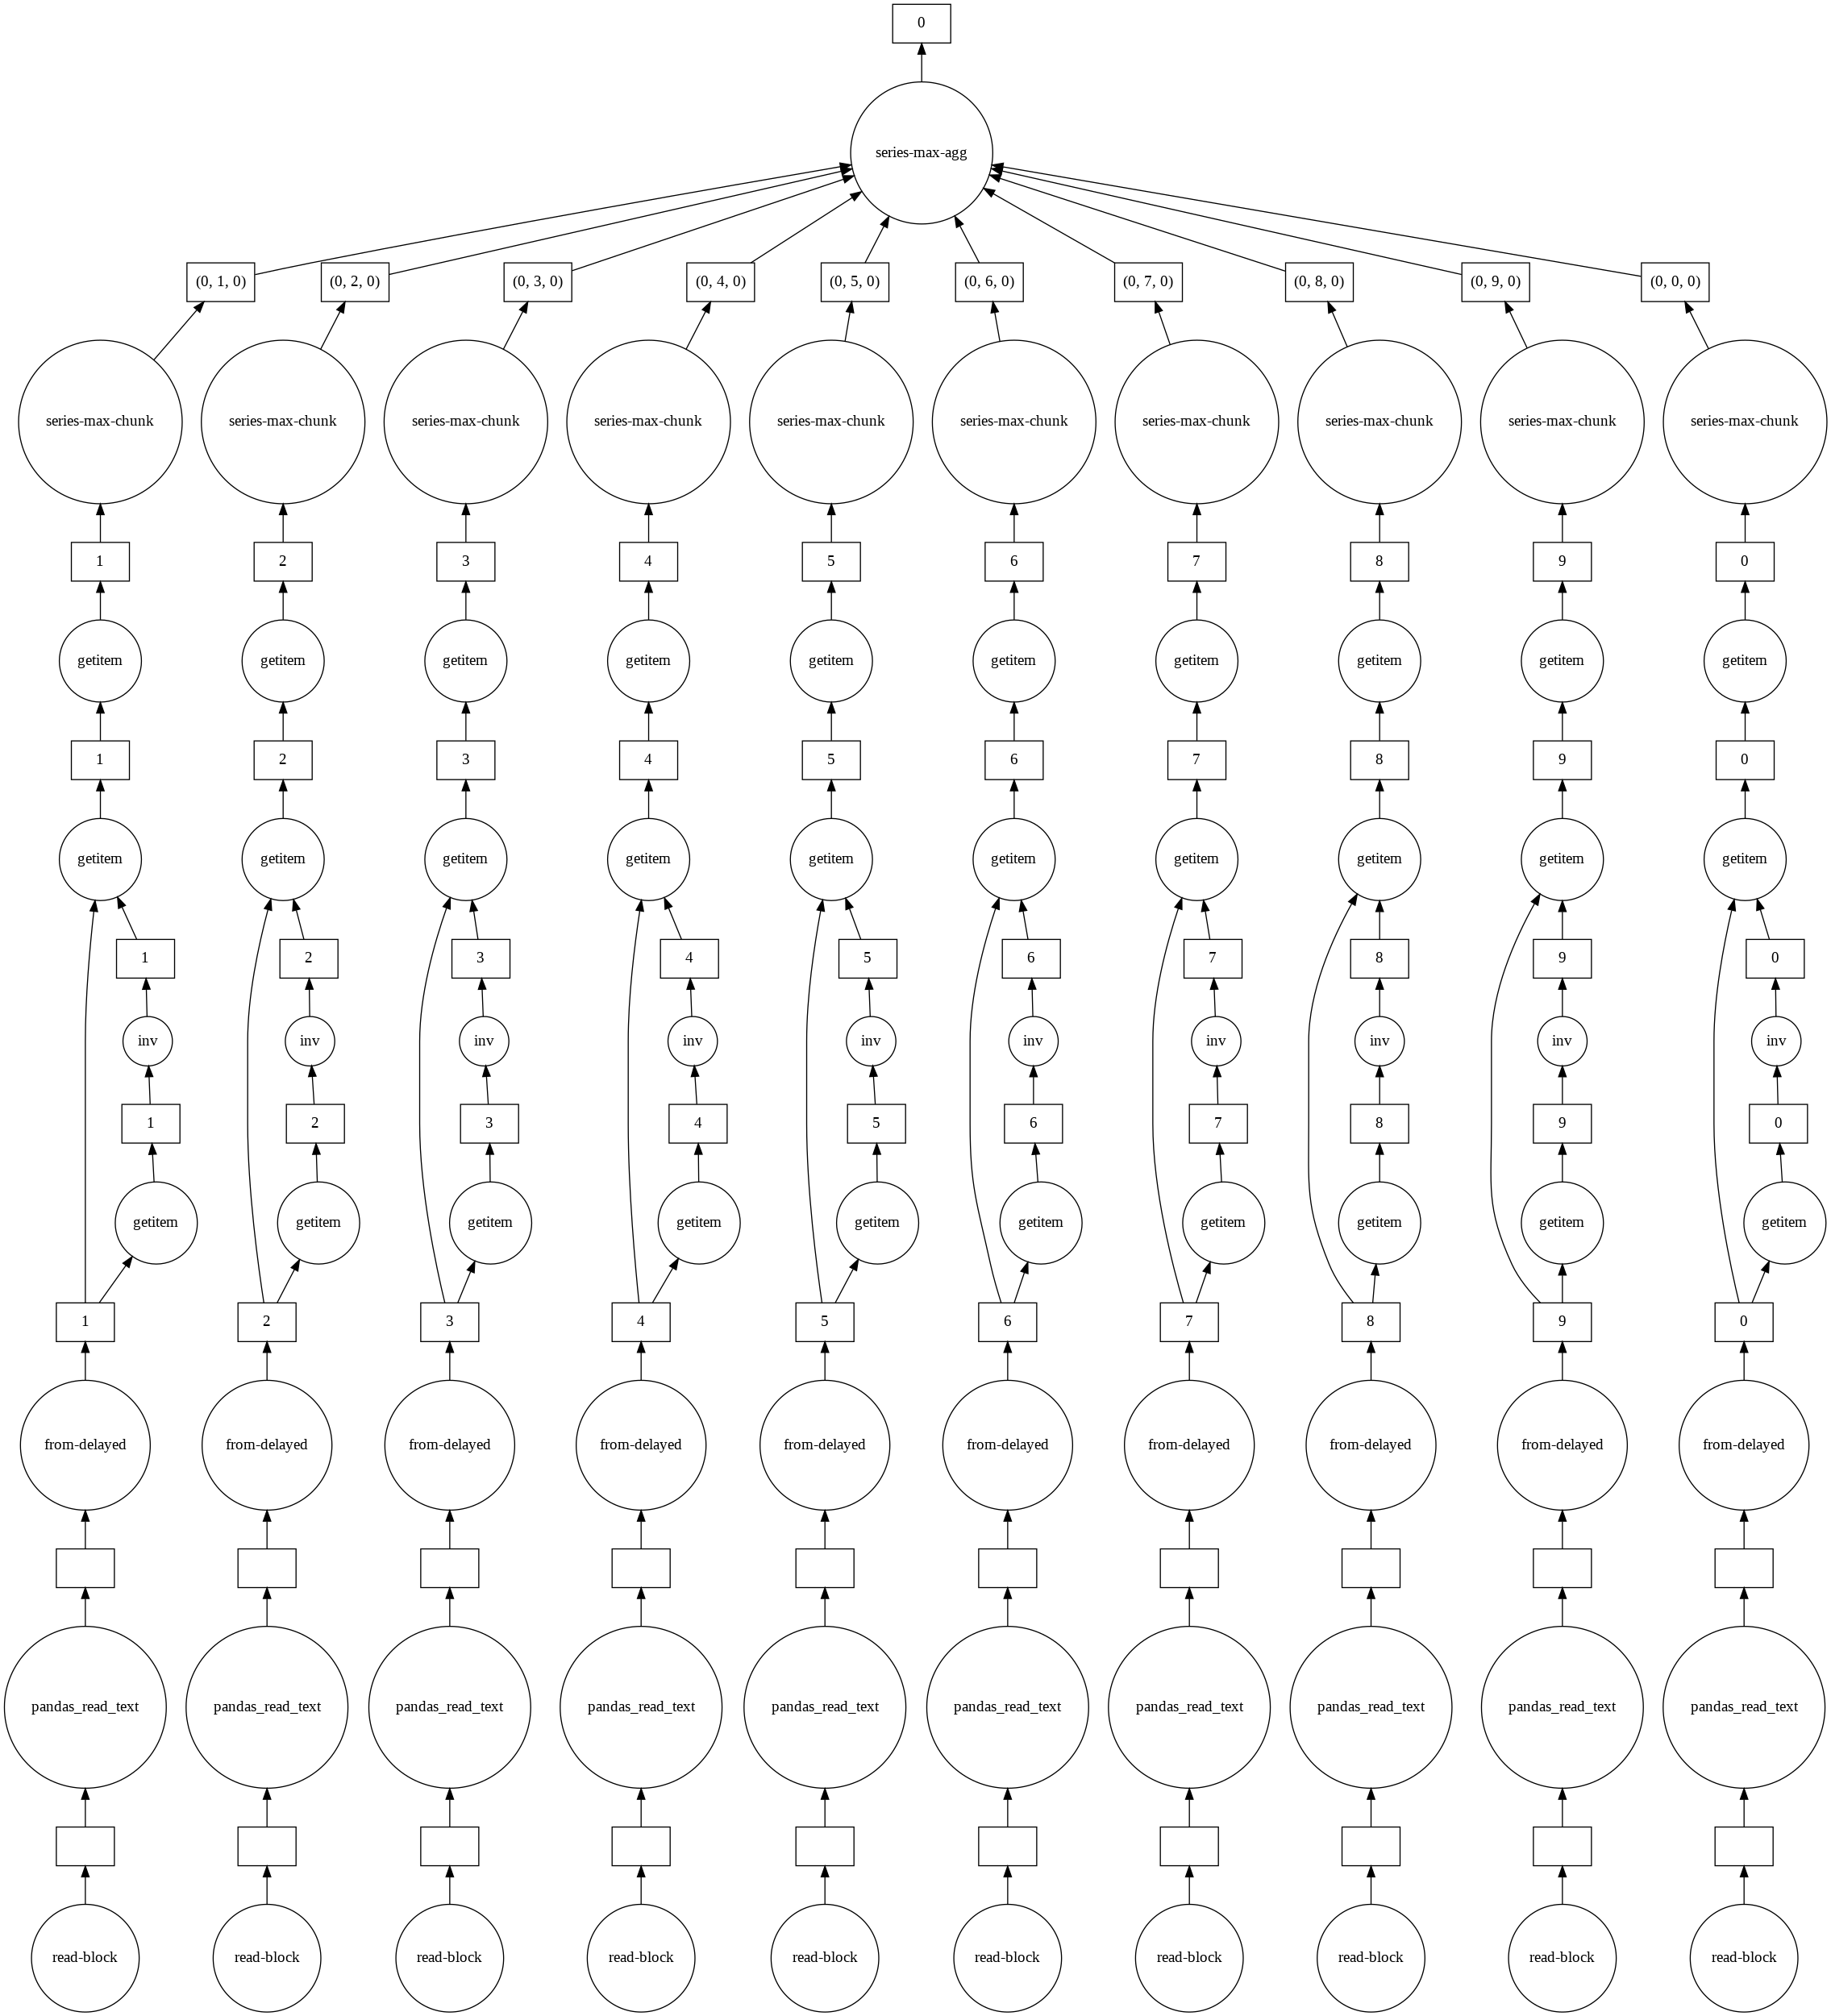

In [3]:
largest_delay.visualize()

### Some Questions to Consider:

- How much speedup is possible for this task (hint, look at the graph).
- Given how many cores are on this machine, how much faster could the parallel schedulers be than the single-threaded scheduler.
- How much faster was using threads over a single thread? Why does this differ from the optimal speedup?
- Why is the multiprocessing scheduler so much slower here?


For single-machine use, the threaded and multiprocessing schedulers are fine choices. They are solid, mature and performant, and require absolutely no set-up. As a rule of thumb, threaded will work well when the functions called release the [GIL](https://wiki.python.org/moin/GlobalInterpreterLock), whereas multiprocessing will always have a slower start-up time and suffer where a lot of communication is required between tasks. The *number* of workers is, in general, also important.



For scaling out work across a cluster, the distributed scheduler is required. Indeed, this is now generally preferred for all work, because it gives you additional monitoring information not available in the other schedulers. (Some of this monitoring is also available with an explicit progress bar and profiler, see [here](https://docs.dask.org/en/latest/diagnostics-local.html).)

## Making a cluster

### Simple method

The `dask.distributed` system is composed of a single centralized scheduler and one or more worker processes. [Deploying](https://docs.dask.org/en/latest/setup.html) a remote Dask cluster involves some additional effort. But doing things locally is just involves creating a `Client` object, which lets you interact with the "cluster" (local threads or processes on your machine). For more information see [here](https://docs.dask.org/en/latest/setup/single-distributed.html). 

Note that `Client()` takes a lot of optional [arguments](https://distributed.dask.org/en/latest/local-cluster.html#api), to configure the number of processes/threads, memory limits and other 

In [4]:
from dask.distributed import Client

# Setup a local cluster.
# By default this sets up 1 worker per core
client = Client()
client.cluster

distributed.utils - ERROR - An asyncio.Future, a coroutine or an awaitable is required
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/opt/conda/lib/python3.7/site-packages/distributed/dashboard/components.py", line 561, in cb
    prof, metadata = await asyncio.gather(prof, metadata)
  File "/opt/conda/lib/python3.7/asyncio/tasks.py", line 719, in gather
    fut = ensure_future(arg, loop=loop)
  File "/opt/conda/lib/python3.7/asyncio/tasks.py", line 592, in ensure_future
    raise TypeError('An asyncio.Future, a coroutine or an awaitable is '
TypeError: An asyncio.Future, a coroutine or an awaitable is required
tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7efd4754b828>>, <Task finished coro=<ProfileTimePlot.trigger_update.<locals>.cb() done, defined at /opt/conda/lib/python

Be sure to click the `Dashboard` link to open up the diagnostics dashboard.



## Executing with the distributed client

Consider some trivial calculation, such as we've used before, where we have added sleep statements in order to simulate real work being done.

In [5]:
from dask import delayed
import time

def inc(x):
    time.sleep(5)
    return x + 1

def dec(x):
    time.sleep(3)
    return x - 1

def add(x, y):
    time.sleep(7)
    return x + y

By default, creating a `Client` makes it the default scheduler. Any calls to `.compute` will use the cluster your `client` is attached to, unless you specify otherwise, as above.


In [8]:
x = delayed(inc)(1)
y = delayed(dec)(2)
total = delayed(add)(x, y)
total.compute()

3

The tasks will appear in the web UI as they are processed by the cluster and, eventually, a result will be printed as output of the cell above. Note that the kernel is blocked while waiting for the result. The resulting tasks block graph might look something like below. Hovering over each block gives which function it related to, and how long it took to execute. ![this](images/tasks.png)

You can also see a simplified version of the graph being executed on Graph pane of the dashboard, so long as the calculation is in-flight.

Let's return to the flights computation from before, and see what happens on the dashboard (you may wish to have both the notebook and dashboard side-by-side). How did does this perform compared to before?

In [9]:
%time largest_delay.compute()

CPU times: user 320 ms, sys: 120 ms, total: 440 ms
Wall time: 2.44 s


1435.0

In this particular case, this should be as fast or faster than the best case, threading, above. Why do you suppose this is? You should start your reading [here](https://distributed.dask.org/en/latest/index.html#architecture), and in particular note that the distributed scheduler was a complete rewrite with more intelligence around sharing of intermediate results and which tasks run on which worker. This will result in better performance in *some* cases, but still larger latency and overhead compared to the threaded scheduler, so there will be rare cases where it performs worse. Fortunately, the dashboard now gives us a lot more [diagnostic information](https://distributed.dask.org/en/latest/diagnosing-performance.html). Look at the Profile page of the dashboard to fund out what takes the biggest fraction of CPU time for the computation we just performed?

If all you want to do is execute computations created using delayed, or run calculations based on the higher-level data collections (see the coming sections), then that is about all you need to know to scale your work up to cluster scale. However, there is more detail to know about the distributed scheduler that will help with efficient usage. See the chapter Distributed, Advanced.

### Exercise

Run the following computations while looking at the diagnostics page. In each case what is taking the most time?

In [15]:
# Number of flights
_ = len(df)

In [16]:
# Number of non-cancelled flights
_ = len(df[~df.Cancelled])

In [17]:
# Number of non-cancelled flights per-airport
_ = df[~df.Cancelled].groupby('Origin').Origin.count().compute()

In [18]:
# Average departure delay from each airport?
_ = df[~df.Cancelled].groupby('Origin').DepDelay.mean().compute()

In [19]:
# Average departure delay per day-of-week
_ = df.groupby(df.Date.dt.dayofweek).DepDelay.mean().compute()

distributed.utils - ERROR - An asyncio.Future, a coroutine or an awaitable is required
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/opt/conda/lib/python3.7/site-packages/distributed/dashboard/components.py", line 561, in cb
    prof, metadata = await asyncio.gather(prof, metadata)
  File "/opt/conda/lib/python3.7/asyncio/tasks.py", line 719, in gather
    fut = ensure_future(arg, loop=loop)
  File "/opt/conda/lib/python3.7/asyncio/tasks.py", line 592, in ensure_future
    raise TypeError('An asyncio.Future, a coroutine or an awaitable is '
TypeError: An asyncio.Future, a coroutine or an awaitable is required
tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7efd4754b828>>, <Task finished coro=<ProfileTimePlot.trigger_update.<locals>.cb() done, defined at /opt/conda/lib/python